In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Download data

In [3]:
!wget -nc https://s3.amazonaws.com/datarobot_public_datasets/DR_Demo_Fire_Ins_Loss_only.csv

File ‘DR_Demo_Fire_Ins_Loss_only.csv’ already there; not retrieving.



## Analysis

In [5]:
df = pd.read_csv('DR_Demo_Fire_Ins_Loss_only.csv')
df.describe()

,loss,Exposure,Property_size,Residents,Norm_fire_risk,Norm_monthly_rent,Loan_mortgage,No_claim_Years,Previous_claims,Norm_area_m,...,crime_residents,crime_area,crime_arson,crime_burglary,crime_neighbour_watch,crime_community,crime_risk,Geographical_risk,Weather_risk,ISO
count,1217.000000,210.000000,1216.000000,1212.000000,1217.000000,1217.000000,196.000000,1217.000000,353.000000,1047.000000,...,910.000000,923.000000,916.000000,922.000000,923.000000,903.000000,923.000000,1211.000000,1213.000000,1217.000000
mean,0.080477,2.809524,3.820724,2.514026,4.040762,1852.694145,3.286935,1.010640,0.320084,34.265521,...,0.958211,0.989317,0.954384,1.044832,0.982719,0.962596,0.992618,1.125001,0.918192,2.889071
std,0.050425,0.726731,1.598589,1.318972,0.232445,1678.089181,0.243295,0.769526,0.500960,25.261731,...,0.403047,0.407156,0.238484,0.523383,0.490376,0.254882,0.358018,1.918566,1.094440,1.598731
min,0.010000,1.000000,1.000000,1.000000,3.776480,500.000000,2.673639,0.000000,0.000000,0.000000,...,0.360578,0.065520,0.472193,0.154595,0.000000,0.522494,0.175763,0.000000,0.000000,1.000000
25%,0.040000,2.000000,3.000000,1.000000,3.898949,783.693499,3.144307,0.000000,0.000000,16.000000,...,0.625186,0.687961,0.739102,0.572656,0.686813,0.739831,0.767780,0.091752,0.273559,2.000000
50%,0.070000,3.000000,3.500000,2.000000,3.898949,1232.882801,3.339025,1.048147,0.000000,30.000000,...,0.903848,0.924562,0.942690,1.019386,0.989819,0.924495,0.974872,0.392954,0.550059,3.000000
75%,0.100000,3.000000,5.000000,4.000000,4.171214,2248.569323,3.474623,1.665109,0.832555,47.000000,...,1.210431,1.190282,1.130489,1.322650,1.191823,1.110430,1.193020,1.059832,1.204226,4.000000
max,0.200000,5.000000,8.000000,6.000000,5.123351,13296.240070,3.714656,2.639501,1.893018,208.000000,...,2.970605,4.145968,1.926021,2.391149,4.322882,2.043525,2.641966,8.548033,9.098934,6.000000


In [41]:
features = dict(
    loss="Numeric",
    crime_burglary="Numeric",
    crime_risk="Numeric",
    ISO_desc="Text",
    Norm_fire_risk="Numeric",
    crime_arson="Numeric",
    ISO="Numeric",
    Weather_risk="Numeric",
    Geographical_risk="Numeric",
    Premium_remain="Numeric",
    Renewal_Type="Categorical",
    Commercial="Categorical",
    crime_property_type="Numeric",
    Renewal_class="Categorical",
    crime_neighbour_watch="Numeric",
    Previous_claims="Numeric",
    Exposure="Numeric",
    crime_area="Numeric",
    ISO_cat="Categorical",
    Norm_monthly_rent="Numeric",
    No_claim_Years="Numeric",
    crime_residents="Numeric",
    Norm_area_m="Numeric",
    Rating_Class="Categorical",
    Property_size="Numeric",
    Residents="Numeric",
    crime_community="Numeric",
    Loan_mortgage="Numeric",
    Premium_renew="Numeric",
    Sub_Renewal_Class="Categorical",
    Sub_Rating_Class="Categorical",
)
numeric = [k for k, v in features.items() if v=='Numeric']
categorical = [k for k, v in features.items() if v=='categorical']
text = [k for k, v in features.items() if v=='text']

### Numeric value correlation

In [19]:
df[numeric].corr().style.background_gradient(cmap='Blues')

,loss,crime_burglary,crime_risk,Norm_fire_risk,crime_arson,ISO,Weather_risk,Geographical_risk,Premium_remain,crime_property_type,crime_neighbour_watch,Previous_claims,Exposure,crime_area,Norm_monthly_rent,No_claim_Years,crime_residents,Norm_area_m,Property_size,Residents,crime_community,Loan_mortgage,Premium_renew
loss,1,-0.0626272,0.00497626,0.0120528,0.0239431,0.0208543,0.0438943,-0.0208381,0.143605,0.0261721,-0.000232171,0.207785,-0.153313,0.0434762,-0.0479096,-0.0216228,-0.045156,0.0190414,0.0356422,-0.00078805,-0.0128741,0.231986,0.0391215
crime_burglary,-0.0626272,1,0.602727,-0.0173151,0.203214,-0.0162625,-0.106134,0.321928,-0.061196,0.467199,0.570248,-0.0574298,-0.178896,0.0473664,-0.0882894,-0.0353305,0.349655,-0.0744681,-0.282155,-0.0709195,0.444191,-0.0245411,-0.05309
crime_risk,0.00497626,0.602727,1,0.0108347,0.371415,-0.0152097,-0.0598327,0.103423,-0.147457,0.934932,0.740145,-0.0461334,-0.255303,0.314909,-0.0566018,-0.012612,0.568004,-0.015228,-0.141722,0.108941,0.551605,-0.0447299,-0.0280346
Norm_fire_risk,0.0120528,-0.0173151,0.0108347,1,0.0729692,-0.00695566,-0.0349587,-0.0170069,-0.0758683,0.0224242,-0.0102435,0.228272,-0.0266254,-0.0204032,0.505618,0.550867,0.0305139,-0.0245311,-0.0558178,0.245639,0.0574043,0.112485,-0.0946721
crime_arson,0.0239431,0.203214,0.371415,0.0729692,1,-0.0274397,0.219227,-0.312055,-0.159657,0.343456,0.293138,-0.0828556,-0.14247,0.481681,0.0471965,0.0601631,0.718161,-0.172607,0.00571411,0.157763,0.934521,0.00389121,0.0129204
ISO,0.0208543,-0.0162625,-0.0152097,-0.00695566,-0.0274397,1,-0.024383,-0.0203945,0.0119265,-0.0138343,-0.00509498,0.012555,0.0300074,-0.0130609,0.00651318,-0.00863487,-0.0263391,0.0134718,0.0518265,0.0138541,-0.0315862,-0.0208727,-0.00346599
Weather_risk,0.0438943,-0.106134,-0.0598327,-0.0349587,0.219227,-0.024383,1,-0.174097,0.0630601,-0.0317487,-0.0163933,0.0646697,0.0208222,0.336356,0.0161328,-0.0280621,0.0639649,-0.0775984,-0.00950068,0.0948234,0.145994,0.219564,-0.0108315
Geographical_risk,-0.0208381,0.321928,0.103423,-0.0170069,-0.312055,-0.0203945,-0.174097,1,-0.0238513,-0.00819843,0.0780631,0.0442513,-0.035026,-0.213451,-0.0454928,-0.0674848,-0.208174,0.074868,-0.394429,-0.108457,-0.210691,-0.095227,-0.0383745
Premium_remain,0.143605,-0.061196,-0.147457,-0.0758683,-0.159657,0.0119265,0.0630601,-0.0238513,1,-0.106048,-0.140968,0.0989203,0.123027,-0.0623862,0.109421,-0.0645121,-0.225757,0.0518045,-0.0682792,0.154234,-0.196714,0.101439,0.0526114
crime_property_type,0.0261721,0.467199,0.934932,0.0224242,0.343456,-0.0138343,-0.0317487,-0.00819843,-0.106048,1,0.611568,-0.0296709,-0.266845,0.338494,-0.0443028,-0.0179145,0.534436,-0.0231689,-0.101059,0.0976882,0.495735,-0.0218605,-0.0182593


### Numeric value distribution

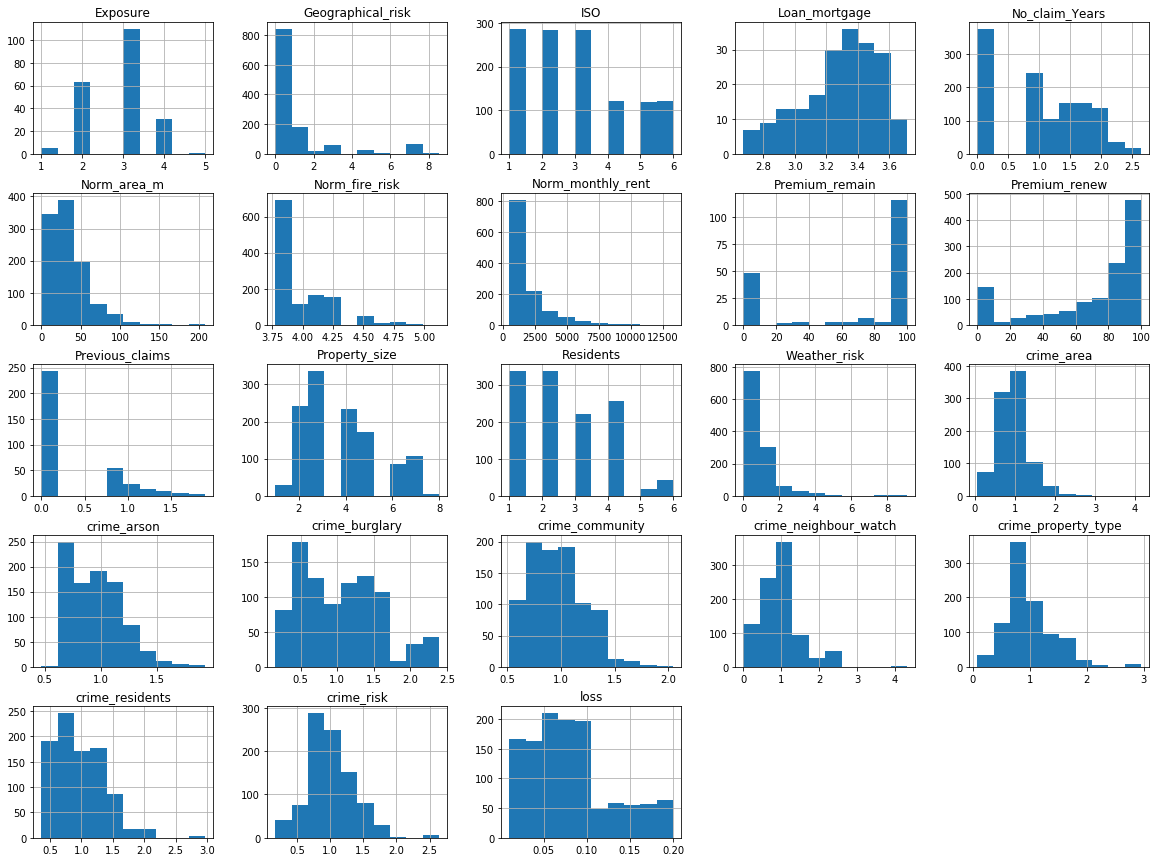

In [16]:
df[numeric].hist(figsize=(20,15));

## Split data

In [22]:
y = df.loss
X = df.loc[:, df.columns != 'loss']
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=42)

## Pipeline
```
categorical  ->  one-hot encoding  ->                 ->
numeric      ->  imputation        -> standarization  -> linear regression
text         ->  tf-idf            ->                 ->
```

In [61]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [43]:
categorical_pipeline = Pipeline(steps=[
    ('imputation', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_pipeline = Pipeline(steps=[
    ('imputation', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

text_pipeline = Pipeline(steps=[
    ('bag of words', CountVectorizer()),
    ('tfidf', TfidfTransformer())
])

In [52]:
numeric = [x for x in numeric if x!='loss']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_pipeline, categorical),
        ('num', numeric_pipeline, numeric),
        ('text', text_pipeline, text)
    ]
)

In [65]:
est = Pipeline(steps=[('preprocessor', preprocessor),
                      ('net', ElasticNet(random_state=42))
])

In [66]:
est.fit(train_X, train_y)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputation',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                   

In [72]:
print(f"MAE: {mean_absolute_error(test_y, est.predict(test_X))}")

MAE: 0.04318852459016393


### Grid search

In [68]:
hyper = dict(
    net__l1_ratio=np.arange(0.05, 1, 0.05), 
    net__alpha=np.arange(0, 1.5, 0.1)
)
grid_search = GridSearchCV(estimator=est, 
                  param_grid=hyper, 
                  scoring='neg_mean_absolute_error', 
                  n_jobs=12, 
                  verbose=3, 
)
grid_search.fit(train_X, train_y)

Fitting 5 folds for each of 285 candidates, totalling 1425 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    1.9s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    3.3s
[Parallel(n_jobs=12)]: Done 588 tasks      | elapsed:    6.0s
[Parallel(n_jobs=12)]: Done 1425 out of 1425 | elapsed:   10.1s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('cat',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputation',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                              

In [69]:
grid_search.best_params_, grid_search.best_estimator_

({'net__alpha': 0.1, 'net__l1_ratio': 0.05}, Pipeline(memory=None,
          steps=[('preprocessor',
                  ColumnTransformer(n_jobs=None, remainder='drop',
                                    sparse_threshold=0.3,
                                    transformer_weights=None,
                                    transformers=[('cat',
                                                   Pipeline(memory=None,
                                                            steps=[('imputation',
                                                                    SimpleImputer(add_indicator=False,
                                                                                  copy=True,
                                                                                  fill_value='missing',
                                                                                  missing_values=nan,
                                                                                  strategy='const

In [71]:
print(f"MAE: {-1*grid_search.best_score_}")

MAE: 0.03885345640529763
